# Homework 4 - Getting to know your customers

Over time, the Banking sector has dabbled into plenty of Data Science applications. The latter includes topics such as Fraud detection, risk modelling for investment, personalized marketing, managing customer data and customer segmentation, among others. The latter is a crucial topic for a bank since they can offer their products more accurately and tailor-made depending on their clients' characteristics and how probable they will consume more services from the bank.

Now, you and your team have been hired by a bank to get to know their customers. In other words, you will implement hashing and clustering techniques to extract relevant information and highlights from those clients and their transactions.

Then, let's get started!

## VERY VERY IMPORTANT!

1. !!! Read the entire homework before coding anything!!! \
2. My solution is not better than yours, and yours is not better than mine. A data-driven analysis does not have a unique way of solving a problem. For this reason, it is crucial (necessary and mandatory) that you describe any single decision you take and all the steps you follow. \
3. Once performed any exercise, comments about the obtained results are mandatory. We are not always explicit about where to focus your comments, but we will always want brief sentences about your discoveries and decisions.

### 1. Finding Similar Costumers

Companies nowadays are implementing product suggestions to provide users with things they are likely to buy. The process often starts by finding similar behaviours among consumers; for this task, we will focus on this part in the specific.
Here you will implement an algorithm to find the most similar match to a consumer given his bank account information. In particular, you will implement your version of the [LSH algorithm](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/) that takes as input information about a consumer and finds people similar to the one in the study.

#### 1.1 Set up the data

1. To start working download the [banking dataset](https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation) on Kaggle.
2. For the sake of this first part, not all columns are necessary since comparing each field single handedly can be quite time-expensive. Then, carefully read the linked guide above and try to understand which features will be appropriate for this task (An heads up: some users have more than one transaction record, make sure to handle them all). Once you have finished, project a version of the dataset to work with.

***

In [2]:
import pandas as pd
import numpy as np
import math
import pickle
import random
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
from tqdm import tqdm
from sklearn.utils import shuffle

In [2]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

Loading and preprocessing of the dataset

In [3]:
data = pd.read_csv('bank_transactions.csv')
data.dropna(inplace=True)

In [4]:
# convert male-female into 0-1
data.CustGender = np.where(data.CustGender=='M', 0, 1)

# from date of birth we create a new column called generations that divides all the ages in 3 classes 
data.CustomerDOB = pd.to_datetime(data.CustomerDOB)
data.loc[data.CustomerDOB.dt.year > 2000,'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000,'CustomerDOB'] - pd.DateOffset(years=100)
data.drop(data.loc[data.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)
data['CustomerAge'] = ((pd.to_datetime('2016/06/15') - data.CustomerDOB)/np.timedelta64(1,'Y')).round(0)
data['CustomerAge'] = data['CustomerAge'].astype(int)
data['Generation'] = pd.cut(x=data.CustomerAge, bins=[0, 30, 60, 120], labels=[11, 12, 13])

# create 100 classes trough quantiles for the variable 'CustAccountBalance'
AccBal_quantiles = list(data.CustAccountBalance.quantile(np.linspace(.01, 1, 99, 0), 'lower'))
AccBal_quantiles.insert(0, -math.inf)
AccBal_quantiles.insert(100, math.inf)
data['BalanceClass'] = pd.cut(x=data.CustAccountBalance, bins=AccBal_quantiles, 
                                  labels=list(range(101, 201)))

# create 10 classes trough quantiles for the variable 'TransactionAmount (INR)'
TransAmount_quantiles = list(data['TransactionAmount (INR)'].quantile(np.linspace(.01, 1, 9, 0), 'lower'))
TransAmount_quantiles.insert(0, -math.inf)
TransAmount_quantiles.insert(10, math.inf)
data['TrAmClass'] = pd.cut(x=data['TransactionAmount (INR)'], bins=TransAmount_quantiles, 
                                  labels=list(range(1001, 1011)))

In [5]:
# create a subset with only the columns needed
sub_data = data[['CustGender', 'Generation', 'BalanceClass', 'TrAmClass']].copy()
sub_data.head()

,CustGender,Generation,BalanceClass,TrAmClass
0,1,11,153,1002
1,0,12,118,1010
2,1,11,153,1006
3,1,12,199,1009
4,1,11,132,1009


In [5]:
# to save as a file
with open("sub_data.pkl", "wb") as file:
    pickle.dump(sub_data, file)

In [ ]:
with open("sub_data.pkl", "rb") as file:
    sub_data = pickle.load(file)

***

#### 1.2 Fingerprint hashing

Using the previously selected data with the features you found pertinent, you have to:

1. Implement your minhash function from scratch. No ready-made hash functions are allowed. Read the class material and search the internet if you need to. For reference, it may be practical to look at the description of hash functions in the [book](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf).

2. Process the dataset and add each record to the MinHash. The subtask's goal is to try and map each consumer to its bin; to ensure this works well, be sure you understand how MinHash works and choose a matching threshold to use. Before moving on, experiment with different thresholds, explaining your choice.

***

Step 1: create the list of shingles (every class of every column)

In [6]:
# initialize the list that will contain all the shingle
shingles = []
# goes trough all the column
for col in sub_data:
    # take all the unique values of that column
    shingles.append(list(sub_data[col].unique()))
# flatten the list
tot_shingles = np.array([item for sublist in shingles for item in sublist])

Step 2: define a function to create the dataframe (rows=shingles | columns=users) that will contain 1 if the user has that shingle and 0 otherwise

In [7]:
def get_shingles_df(data):
    # initialize the dictionary that will have the users as columns and the shingles as rows
    feature_dict = defaultdict(list)

    for row in range(len(data)):
        user = np.array(data.iloc[row])
        for shingle in tot_shingles:
            if shingle in user:
                feature_dict[row].append(1)
            else:
                feature_dict[row].append(0)
                    
    return pd.DataFrame.from_dict(feature_dict)

In [8]:
shingles_df = get_shingles_df(sub_data)
shingles_df.head()

,0,1,2,3,4,5,6,7,8,9,...,985312,985313,985314,985315,985316,985317,985318,985319,985320,985321
0,1,0,1,1,1,1,1,0,1,0,...,1,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,1,...,0,0,1,1,1,1,1,1,1,1
2,1,0,1,0,1,0,1,0,1,0,...,0,1,1,0,1,1,1,1,0,0
3,0,1,0,1,0,1,0,1,0,1,...,1,0,0,1,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# to save as a file
with open("shingles_df.pkl", "wb") as file:
    pickle.dump(shingles_df, file)

In [5]:
with open("shingles_df.pkl", "rb") as file:
    shingles_df = pickle.load(file)

Step 3: define a function to create the signature matrix (rows=permutations | columns=users) that contains the position of the first non zero values 

In [9]:
def get_signature_matrix(shingles_df, permutations):
    # Creating the signature matrix
    sig_mat_dict = dict()
    seed = 123
    for perm in range(permutations):
        seed += 1
        permuted_df = shuffle(shingles_df, random_state=seed)
        sig_mat_dict[perm] = list(permuted_df.ne(0).idxmax()+1)
        
    return pd.DataFrame.from_dict(sig_mat_dict).transpose()

In [10]:
n_permutations = 64
signature_matrix = get_signature_matrix(shingles_df, n_permutations)
signature_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,985312,985313,985314,985315,985316,985317,985318,985319,985320,985321
0,6,2,6,4,1,4,11,2,1,2,...,4,1,2,2,2,2,2,2,2,2
1,106,7,3,8,3,110,3,111,3,14,...,22,3,63,2,3,3,3,3,2,2
2,1,107,1,1,1,1,1,12,1,113,...,1,1,110,107,3,102,3,110,19,68
3,6,7,6,8,3,4,11,111,3,113,...,22,3,2,2,2,102,48,2,2,2
4,106,7,6,4,9,110,110,12,3,14,...,110,3,63,89,3,110,3,110,19,68


In [16]:
# to save as a file
with open("signature_matrix.pkl", "wb") as file:
    pickle.dump(signature_matrix, file)

In [6]:
with open("signature_matrix.pkl", "rb") as file:
    signature_matrix = pickle.load(file)

Step 4: define an hashing function (not necessary)

In [11]:
# creating my hash function
def my_hash(key, length):
    random.seed(123)
    alpha = random.sample(range(1000000), length)
    beta = random.sample(range(1000000), length)
    return np.dot(alpha*np.array(key), beta)%1000003

Step 5: define a function to assign every user to a bucket

In [12]:
# create a function that given the signature matrix and the number of bands return the buckets
def assign_buckets(sig_matrix, permutations, n_bands):
    # how many rows to consider
    rows = int(permutations / n_bands)
    # initialize the dict for the buckets
    bucks = dict()
    # goes trough every users
    for col in sig_matrix:
        # goes trough chunks of shingles
        for i in range(0, len(sig_matrix), rows):
            # create the keys for the buckets
            bucket_hash = my_hash(tuple(sig_matrix[col].iloc[i : i + rows]), rows)
            # if the key is already in the dict we only add the column otherwise we create a 'new entry'
            if bucket_hash in bucks:
                bucks[bucket_hash].add(col)
            else:
                bucks[bucket_hash] = {col}
    return bucks

Step 6: try with different bands in order to choose the best one

In [12]:
bands_list = [2, 4, 8, 16]

for band in bands_list:
    buckets = assign_buckets(signature_matrix, n_permutations, band)
    buckets_len = []
    for key in buckets.keys():
        buckets_len.append(len(buckets[key]))
    print(f'With band length equal to {band} --> {len(buckets)} different buckets have been created')
    print(f'With band length equal to {band} --> The average length of the buckets is: {round(np.mean(buckets_len), 2)}')

985322it [05:26, 3014.90it/s]         


With band length equal to 2 --> 11253 different buckets have been created
With band length equal to 2 --> The average length of the buckets is: 175.12


985322it [07:42, 2129.66it/s]         


With band length equal to 4 --> 22218 different buckets have been created
With band length equal to 4 --> The average length of the buckets is: 177.39


985322it [13:28, 1218.18it/s]         


With band length equal to 8 --> 38181 different buckets have been created
With band length equal to 8 --> The average length of the buckets is: 206.45


985322it [24:12, 678.50it/s]                    


With band length equal to 16 --> 33820 different buckets have been created
With band length equal to 16 --> The average length of the buckets is: 454.53


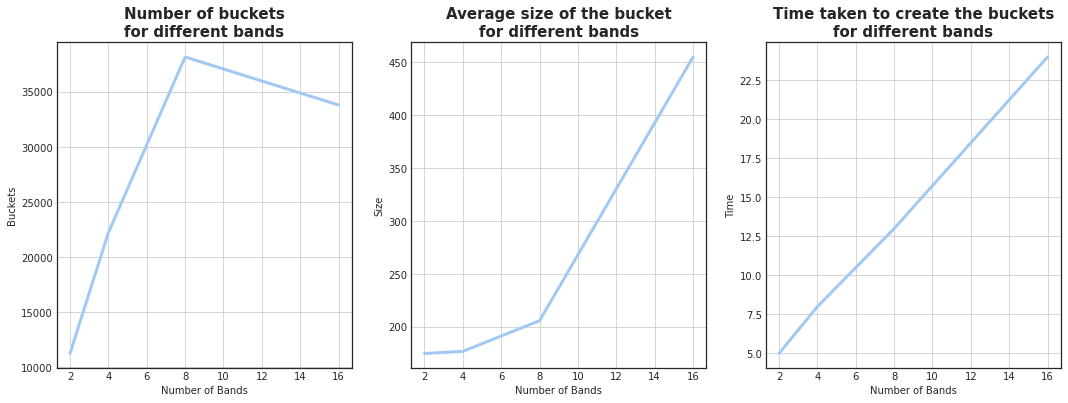

In [14]:
time_list = [5, 8, 13, 24]
buckets_number = [11253, 22218, 38181, 33820]
buckets_length = [175, 177, 206, 455]

plt.figure(1, figsize=(18,6))

color1 = sns.color_palette("pastel")[0]

with plt.style.context("seaborn-white"):
    plt.rcParams["axes.grid"] = True
    plt.subplot(1, 3, 1)
    a = sns.lineplot(x=bands_list, y=buckets_number, color=color1, linewidth=3)
    plt.title("Number of buckets\nfor different bands", fontsize='15', fontweight="bold")
    plt.xlabel("Number of Bands")
    plt.ylabel("Buckets")

with plt.style.context("seaborn-white"):
    plt.rcParams["axes.grid"] = True
    plt.subplot(1, 3, 2)
    b = sns.lineplot(x=bands_list, y=buckets_length, color=color1, linewidth=3)
    plt.title('Average size of the bucket\nfor different bands', fontsize='15', fontweight="bold")
    plt.xlabel("Number of Bands")
    plt.ylabel('Size')

with plt.style.context("seaborn-white"):
    plt.rcParams["axes.grid"] = True
    plt.subplot(1, 3, 3)
    c = sns.lineplot(x=bands_list, y=time_list, color=color1, linewidth=3)
    plt.title('Time taken to create the buckets\nfor different bands', fontsize='15', fontweight="bold")
    plt.xlabel("Number of Bands")
    plt.ylabel('Time')

plt.show()

The best choice is to set n_bands equal to: 8

In [13]:
n_bands = 8
buckets = assign_buckets(signature_matrix, n_permutations, n_bands)

In [31]:
# to save as a file
with open("buckets.pkl", "wb") as file:
    pickle.dump(buckets, file)

In [47]:
with open("buckets.pkl", "rb") as file:
    buckets = pickle.load(file)

***

#### 1.3 Locality Sensitive Hashing

Now that you prepared your algorithm, it's query time!
We have prepared some dummy users for you to work with.

Download [this csv](https://drive.google.com/file/d/1ob7l9vuujfy8cSNWlpt1shcHWXeLHxPs/view?usp=sharing) and report the most similar users (comparing them against the dataset provided in Kaggle).
Did your hashing method work properly, what scores have you obtained and how long did it take to run? Provide information and analysis about the results.

***

Loading and preprocessing the query dataset

In [14]:
query = pd.read_csv('query_users.csv')
query.dropna(inplace=True)

In [15]:
# all the transformations done before for the dataset

query.CustomerDOB = pd.to_datetime(query.CustomerDOB)
query.loc[query.CustomerDOB.dt.year > 2000,'CustomerDOB'] = query.loc[query.CustomerDOB.dt.year > 2000,'CustomerDOB'] - pd.DateOffset(years=100)
query.drop(query.loc[query.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

query.CustGender = np.where(query.CustGender=='M', 0, 1)

query['CustomerAge'] = ((pd.to_datetime('2016/06/15') - query.CustomerDOB)/np.timedelta64(1,'Y')).round(0)
query['CustomerAge'] = query['CustomerAge'].astype(int)

query['Generation'] = pd.cut(x=query.CustomerAge, bins=[0, 30, 60, 120], labels=[11, 12, 13])

query['BalanceClass'] = pd.cut(x=query.CustAccountBalance, bins=AccBal_quantiles, 
                                  labels=list(range(101, 201)))

query['TrAmClass'] = pd.cut(x=query['TransactionAmount (INR)'], bins=TransAmount_quantiles, 
                                  labels=list(range(1001, 1011)))

In [16]:
# creating a subset of the query with only the features needed
sub_query = query[['CustGender', 'Generation', 'BalanceClass', 'TrAmClass']].copy()
sub_query.head()

,CustGender,Generation,BalanceClass,TrAmClass
0,0,12,184,1003
1,0,11,134,1010
2,0,11,133,1007
3,0,11,176,1008
4,0,11,182,1003


***

Now we want to apply all the steps excecuted before and we want to check if the queries will end up in the buckets generated earlier for the users of the main dataset.

In [18]:
# apply all the functions created earlier for each user of the query
q_user_buckets = dict()
for row in range(len(sub_query)):
    query_user = sub_query.iloc[row:row+1]
    query_shingles_matrix = get_shingles_df(query_user)
    query_sig_matrix = get_signature_matrix(query_shingles_matrix, n_permutations)
    query_buckets = assign_buckets(query_sig_matrix, n_permutations, n_bands)
    q_user_buckets[row] = list(query_buckets.keys())
# check the proportion of permutations of the query that went in an existing bucket
found = []
for q_keys in list(q_user_buckets.keys()):
    for q_val in list(q_user_buckets[q_keys]):
        try:
            buckets[q_val]
            found.append(1)
        except:
            found.append(0)
np.mean(found)

1.0

We get 1, that means that every permutations applied to every query users ended up in a already existing bucket. That is a good thing because it suggests that our algorithm does what it is supposed to do.

***

Let's now define two functions, the first one to calculate the Jaccard Similarity, the second one to return the top n similar users to the one given as a query. To order the results we will use the Jaccard Similarity applied only to the users that belongs to the buckets where our query will end up.

Jaccard Similarity:

$$ J(A,B) = \frac{A \cap B}{A \cup B} $$

In [19]:
# define the jaccard similarity function 
def jaccard(x, y):
    inters = set(x).intersection(set(y))
    return float(len(inters))/(len(x)+len(y)-len(inters))

In [20]:
# define a function that takes as input the index of the query user and return the top n similar user of the dataset
def find_similar(user, n):
    similar_users = defaultdict(list)
    similar_buckets = q_user_buckets[user]
    for bucket in similar_buckets:
        similar_users[user].append(list(buckets[bucket]))
    similar_users[user] = set(np.array([item for sublist in similar_users[user] for item in sublist]))
    user_similarity = dict()
    for user_found in similar_users[user]:
        user_similarity[user_found] = jaccard(sub_query.iloc[user], sub_data.iloc[user_found])
    sorted_score = dict(sorted(user_similarity.items(), key=lambda item: item[1], reverse=True))
    indexes = list(sorted_score.keys())
    similarities = []
    for i in range(n):
        similarities.append(sorted_score[indexes[i]])
        to_add = sub_data.iloc[indexes[i]:indexes[i]+1]
        if i > 0:
            out = pd.concat([out, to_add])
        else:
            out = to_add
    out['Similarity'] = similarities
    
    return out

***

Let's try our function for different queries and different n to check if it really returns similar users.

- Example 1:

In [31]:
user_query = 0
n = 3
similar_user_to_q = find_similar(user_query, n)
query_submitted = sub_query[user_query:user_query+1]
display('query_submitted', 'similar_user_to_q')

query_submitted
   CustGender Generation BalanceClass TrAmClass
0           0         12          184      1003

similar_user_to_q
        CustGender Generation BalanceClass TrAmClass  Similarity
235707           0         12          184      1003         1.0
166035           0         12          184      1003         1.0
655058           0         12          184      1003         1.0

***
- Example 2:

In [30]:
user_query = 10
n = 5
similar_user_to_q = find_similar(user_query, n)
query_submitted = sub_query[user_query:user_query+1]
display('query_submitted', 'similar_user_to_q')

query_submitted
    CustGender Generation BalanceClass TrAmClass
10           0         11          130      1005

similar_user_to_q
        CustGender Generation BalanceClass TrAmClass  Similarity
289881           0         11          130      1005         1.0
803053           0         11          130      1005         1.0
289885           0         11          130      1005         1.0
313858           0         11          130      1005         1.0
118222           0         11          130      1005         1.0

***
- Example 3:

In [32]:
user_query = 40
n = 10
similar_user_to_q = find_similar(user_query, n)
query_submitted = sub_query[user_query:user_query+1]
display('query_submitted', 'similar_user_to_q')

query_submitted
    CustGender Generation BalanceClass TrAmClass
44           0         12          192      1005

similar_user_to_q
        CustGender Generation BalanceClass TrAmClass  Similarity
746392           0         12          192      1005         1.0
496328           0         12          192      1005         1.0
465810           0         12          192      1005         1.0
461470           0         12          192      1005         1.0
878796           0         12          192      1005         1.0
494199           0         12          192      1005         1.0
509574           0         12          192      1005         1.0
44068            0         12          192      1005         1.0
116105           0         12          192      1005         1.0
419932           0         12          192      1005         1.0

We can say that our algorithm works properly, for each example it has returned the supposed results.

***

### 2. Grouping customers together!

Now we will deal with clustering algorithms that will provide groups of clients which are similar among them.

To solve this task, you must accomplish the following stages:

#### 2.1 Getting your data + feature engineering

1. Access to the data found in [this dataset](https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation) (it is the same dataset from the previous question 1.1).

2. Sometimes, the features (variables, fields) are not given in a dataset but can be created from it. The previous step is known as feature engineering. For example, the original dataset has several transactions done by the same customer. Then, we ask you to group data by the client (using CustomerId) and, based on it, create the following new features for each CustomerId: \
a) Number of transactions \
b) Number of transactions with a balance bigger than 100 USD
c) Average amount of the transactions
d) Average balance
e) Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).
f) Gender of the customer
h) Most frequent location of the customer

So, in the end, you should have for each CustomerID seven features.

3. Consider at least 20 additional features that can be generated for each CustomerId. Describe each of them and why you believe they will be helpful. Moreover, add it to the previous dataset (the one with seven features). In the end, you should have for each CustomerID at least 27 features (7 recommended + 20 suggested by you).

_Hints for feature engineering:_

***

#### 2.2 Choose your features (variables)!
As you may notice, you have plenty of features to work with now. So, you need to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the subsequent directions to achieve it:

1. To normalise or not to normalise? That's the question. Sometimes it is worth normalising (scaling) the features. Explain if it is a good idea to perform any normalisation method. If you think the normalisation should be used, apply it to your data (look at the available normalisation functions in the scikit-learn library).

2. Select one method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

3. Apply the selected method(s) to your data. Ensure the chosen method retains > 70% of the total variance.

***

***

#### 2.3 Clustering!

1. Implement the K-means clustering algorithm (not ++: random initialization). We ask you to write the algorithm from scratch following what you learned in class. !! We also ask you to use MapReduce in your K-means algorithm.

2. Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

3. Run the algorithm on the data.

4. Then, use the already implemented version of K-means++ (from the scikit-learn library). Explain the differences (if there are any) in the results.

***

In [ ]:
def my_map(X, centroids, k):
    # dictionary that will contain as a key the label and as a value the list of x associated
    couples = defaultdict(list)
    # initialize the loss function
    loss_function = 0
    # goes trough every row in the dataset (x)
    for i in range(X.shape[0]):
        # initialize the dict that will contain the distances from x to every centroid
        distances = dict()
        x = np.array(X.iloc[i])
        # goes trough every centroid
        for j in range(k):
            centroid = np.array(centroids.iloc[j])
            # calculate the euclidean distance
            distances[np.linalg.norm(x - centroid)] = (i, j)
        # takes the minimum distance to associate the x with the centroid
        argmin = np.min(list(distances.keys()))
        loss_function += argmin
        couples[distances[argmin][1]].append(distances[argmin][0])
    return couples, loss_function

In [ ]:
def my_reduce(X, couples):
    iterations = 0
    # goes trough every centroid
    for key in couples.keys():
        #total = np.array([0, 0])
        total = np.repeat(0, X.shape[1])
        # goes trough every element associated to that centroid
        for element in couples[key]:
            x = np.array(X.iloc[element])
            total = np.sum([total, x], axis=0)
        # calculates the new coordinates of the centroid like an average of the coordinates 
        new_coord = np.array(total/len(couples[key]))
        new_coord_df = pd.DataFrame([new_coord])
        # create a df that contains all the new centroids
        if iterations == 0:
            new_centroids = new_coord_df
        else:
            new_centroids = pd.concat([new_centroids, new_coord_df])
        iterations += 1
    return new_centroids

In [ ]:
def my_kmeans(X, k):
    # setting the maximum number of iterations allowed 
    max_iter = 100
    # setting the objective function threshold for the stopping
    eps = 0.1
    # chose at random the k starting centroids
    centroids = X.sample(n = k)
    # initialize the loss function list
    loss_history = []
    # now until we reach one of the two stopping conditions we want to apply the map and reduce functions
    for i in tqdm(range(max_iter)):
        new_labels, loss = my_map(X, centroids, k)
        loss_history.append(loss)
        if i>0:
            if loss_history[i-1]-loss_history[i] < eps:
                break
        centroids = my_reduce(X, new_labels)
    return new_labels, loss_history[:-1], i

In [ ]:
prova1, prova2, prova3 = my_kmeans(df, 3)
print(prova2)
print(prova3)

***

#### 2.4 Analysing your results!

You are often encouraged to explain the main characteristics that your clusters have. This is called the Characterizing Clusters step. Thus, follow the next steps to do it:

1. Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, CustGender, Number of transactions, etc.

2. Most of your selected variables will be numerical (continuous or discrete), then categorise them into four categories.

3. With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

4. Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100. The sample example for clustering with K = 4 and Gender variable:

5. Interpret the results for each pivot table.

6. Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?).

#### IMPORTANT NOTE:

- We know you may consult the internet for information about implementing the requested algorithms. However, the final code must be yours! So please, do not search and copy-paste the code.

- Since we know that some of the previous points can raise many questions, opening a thread on Slack is recommended and welcomed.

- Unfortunately, there are no explicit descriptions of the features in the data sets. Nevertheless, the names are usually self-explanatory. In case you have any doubt, Google will help you better understand the characteristics of a bank's customer.

### Bonus

We remind you that we consider and grade the bonuses only if you complete the entire assignment.

1. Think about any two other clustering algorithms that you would like to use for the dataset (of course, you can use implemented version of them, e.g. from the scikit-learn library). Compare the results of chosen two algorithms with K-means implemented by you and K-means++ (from the scikit-learn library). Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

### Command Line Question

Here is another command line question to enjoy. We previously stated that using the command line tools is a skill that Data Scientists must master.

In this question, you should use any command line tools that you know to answer the following questions using the same dataset that you have been using so far:

1. Which location has the maximum number of purchases been made?
2. In the dataset provided, did females spend more than males, or vice versa?
3. Report the customer with the highest average transaction amount in the dataset.

__Note__: You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable.

### Algorithmic Question

An imaginary university wants to restrict its student’s entrance to the campus. Suppose that there are N entrances, M students and G guards. Due to the security measures, each student is known to be assigned a gate through which they should enter the university.

The N entrances will be numbered from 1 to N. Regarding one entry, the entrance will be opened right before the first student’s arrival and closed right after the arrival of the last student that should enter through that specific entrance. We will assume that two students can not enter the university simultaneously. For an entry to be protected, a guard should be assigned to it. Notice that a guard cannot leave his post until the door he was given is closed.

Assume that the university's head of the guards knows the order in which the students are coming to the university (yeah, they know you more than you know about yourself!). He wants you to help him if having only G guards is enough to address the restrictions they wish to apply (in other words, whether there will be a moment when more than G entrances should be opened or not).

__Input__

In the first line, you will be given the values of N, M and G, which correspond to the number of entrances to the university, the number of students in the university and the number of guards that the head of the guards intends to use to apply these restrictions respectively.

\begin{align}
1 &\leq N \leq 10^6 \\
1 &\leq M \leq 10^3 \\
1 &\leq G \leq 100 \\
\end{align}

In the second line, you will be given M integers which the ith integer corresponds to the entrance that has been assigned to the ith student to enter the university. Students will enter the university in the same order .

__Ouptut:__

Output “YES” if having G guards is enough to respect the restrictions, and “NO” if it is not enough.

__Examples:__

__Input 1__

__Output 2__

In this example, we only have one guard in the university. Initially, the guard will be assigned to protect entrance 1'. After the second student arrives, the guard will close access ‘1' and go to entrance '3'. In this case, having only one guard is enough to address the restrictions.

__Input 2__

__Output 2__